In [19]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
import random

In [20]:
# Randomly select a defined number of image paires from a given dataset
def get_left_min_image_combinations(number_image_pairs_selected, image_data, image_labels):
    
    num_images_total = len(image_labels)
    
    image_combination_data = []
    image_combination_labels = []
    
    for i in range(number_image_pairs_selected):
        
        # Draw two image indices from a uniform random distribution
        random_index_A = random.randint(0, num_images_total-1)
        random_index_B = random.randint(0, num_images_total-1)
        
        # Randomly choose two images from the dataset
        image_A = image_data[random_index_A]
        image_B = image_data[random_index_B]
        
        # Find the minimum between the two labels
        label_A = image_labels[random_index_A]
        label_B = image_labels[random_index_B]
        minimum_label = min(label_A, label_B)
        
        if label_A < label_B:
            # Merge images TODO: this could be a function with several options
            combined_images = np.hstack((image_A, image_B))
        elif label_A > label_B: 
            # Merge images TODO: this could be a function with several options
            combined_images = np.hstack((image_B, image_A))
        # Here we want to exclude the images where they are the same on both sides
            
   
        # Append newly generated image combination and minimum label to list
        image_combination_data.append(combined_images)
        image_combination_labels.append(minimum_label)
        
    # Convert image data and labels lists to numpy arrays
    image_combination_data = np.array(image_combination_data)
    image_combination_labels = np.array(image_combination_labels)
    
    return image_combination_data, image_combination_labels

In [21]:
# Randomly select a defined number of image paires from a given dataset
def get_right_min_image_combinations(number_image_pairs_selected, image_data, image_labels):
    
    num_images_total = len(image_labels)
    
    image_combination_data = []
    image_combination_labels = []
    
    for i in range(number_image_pairs_selected):
        
        # Draw two image indices from a uniform random distribution
        random_index_A = random.randint(0, num_images_total-1)
        random_index_B = random.randint(0, num_images_total-1)
        
        # Randomly choose two images from the dataset
        image_A = image_data[random_index_A]
        image_B = image_data[random_index_B]
        
        # Merge images TODO: this could be a function with several options
        combined_images = np.hstack((image_A, image_B))
        
        # Find the minimum between the two labels
        label_A = image_labels[random_index_A]
        label_B = image_labels[random_index_B]
        minimum_label = min(label_A, label_B)
        
        if label_A < label_B:
            # Merge images TODO: this could be a function with several options
            combined_images = np.hstack((image_B, image_A))
        elif label_A > label_B: 
            # Merge images TODO: this could be a function with several options
            combined_images = np.hstack((image_A, image_B))
        # Here we want to exclude the images where they are the same on both sides
            
   
        # Append newly generated image combination and minimum label to list
        image_combination_data.append(combined_images)
        image_combination_labels.append(minimum_label)
        
    # Convert image data and labels lists to numpy arrays
    image_combination_data = np.array(image_combination_data)
    image_combination_labels = np.array(image_combination_labels)
    
    return image_combination_data, image_combination_labels

In [22]:
# Load data and split into training and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [23]:
# Split training set further into training and validation sets
sample_size = 40000
X_train, X_val, y_train, y_val = train_images[:sample_size], train_images[sample_size:sample_size*2],  train_labels[:sample_size], train_labels[sample_size:sample_size*2]

In [24]:
combo_train_X, combo_train_y = get_left_min_image_combinations(40000, X_train, y_train)
combo_val_X, combo_val_y = get_right_min_image_combinations(20000, X_val, y_val)

In [25]:
# Reshape the data so they can be fed into the network, one-hot-encode the labels

train_images = combo_train_X.reshape((combo_train_X.shape[0], 28, 56, 1))
train_images = train_images/ 255

val_images = combo_val_X.reshape((combo_val_X.shape[0], 28, 56, 1))
val_images = val_images/255

train_labels = to_categorical(combo_train_y)
val_labels = to_categorical(combo_val_y)

In [26]:
# Experiment parameters

num_epochs = 5

In [27]:
# Model architecture
def build_CNN():

    # Convolutional NN
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,56,1)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    # Adding a NN Classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(10, activation = 'softmax'))

    model.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy', 'mae'])

    return model

In [28]:
CNN_model = build_CNN()
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 54, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 27, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 12, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 10, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

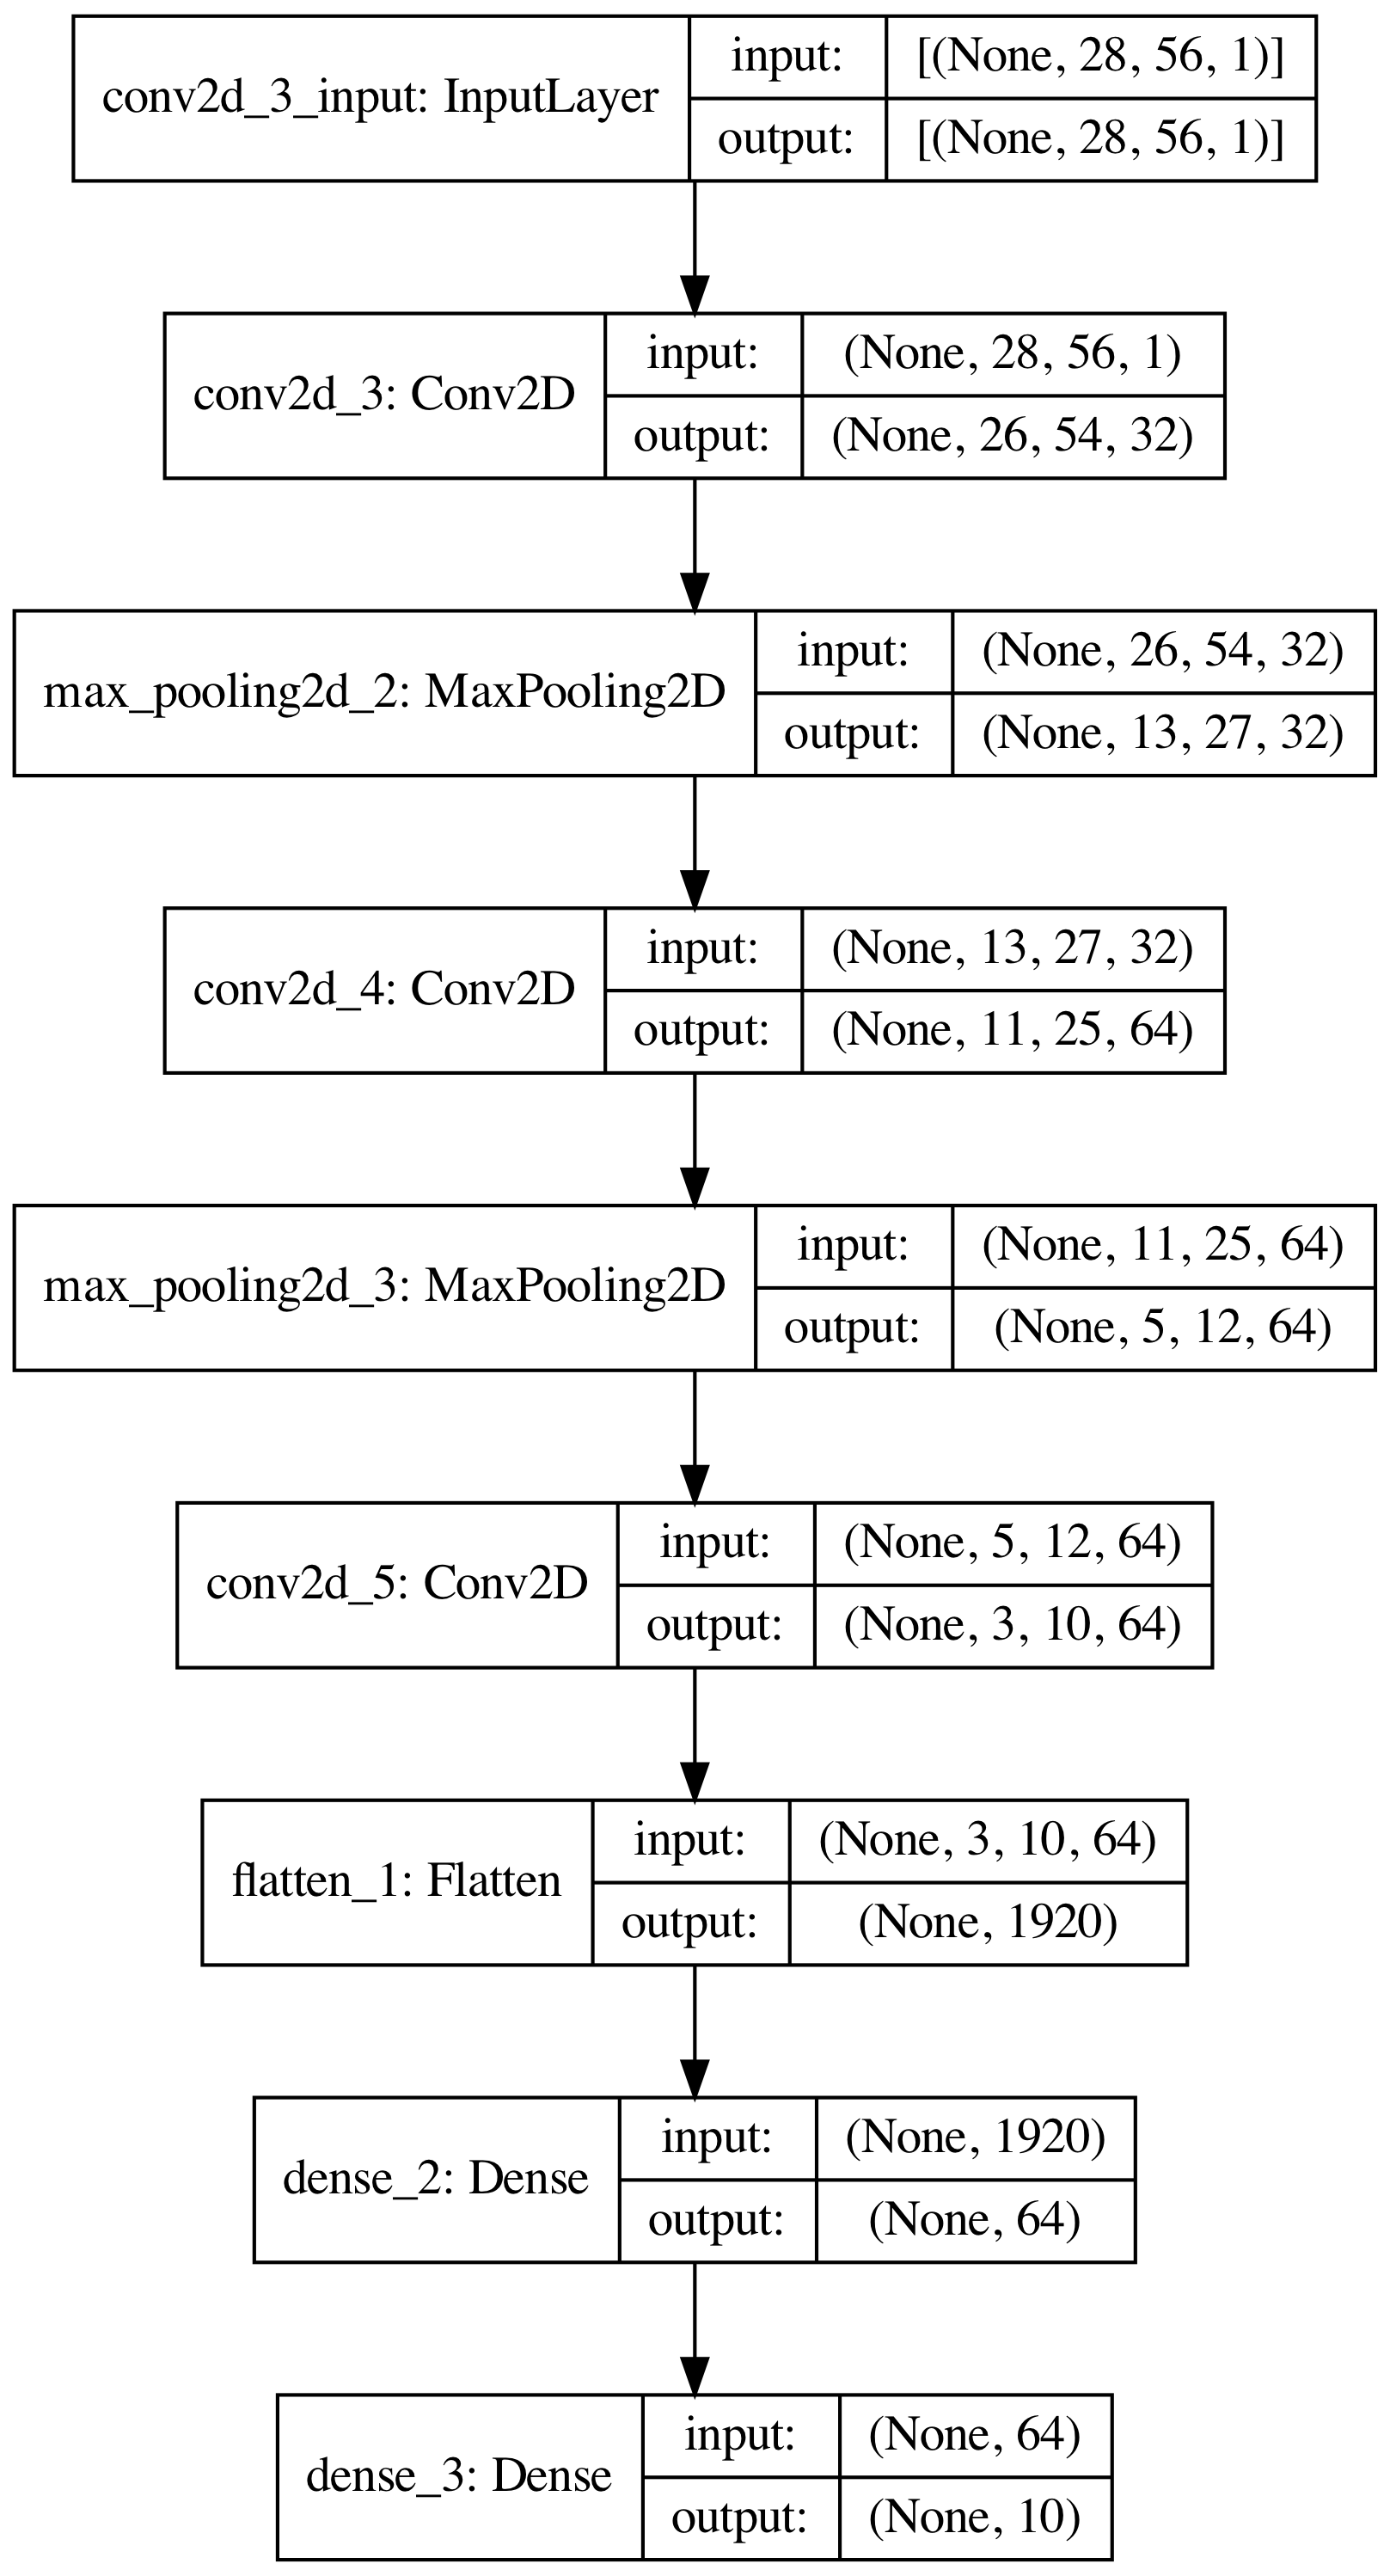

In [56]:
tf.keras.utils.plot_model(CNN_model, "CNN_model.png", show_shapes=True, dpi=300)

In [39]:
# Cross-validate
# Set up parameters for k-fold cross-validation
k = 4
num_val_samples = len(train_images)//k

num_epochs = 5
all_mae_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    model = build_CNN()
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    val_mae_history = history.history['val_accuracy']
    all_mae_histories.append(val_mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [37]:
val_acc_history = history.history['val_accuracy']
val_acc_history

[0.11264999955892563,
 0.11620000004768372,
 0.11755000054836273,
 0.10989999771118164,
 0.11084999889135361]

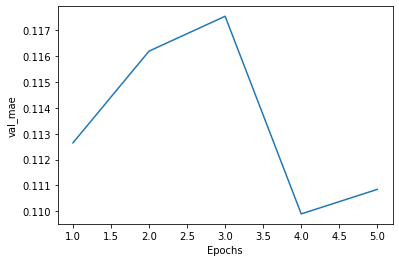

In [36]:
# Compute the average of the per-epoch MAE scores for all folds
# Building the history of successive mean K-fold validation scores
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history)
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()

In [49]:
# Print loss, mae and accuracy
CNN_eval_model = CNN_model.evaluate(val_images, val_labels)
CNN_eval_model

625/625 [==============================] - 3s 4ms/step - loss: 21.9947 - accuracy: 0.1108 - mae: 0.1777


[21.99468994140625, 0.11084999889135361, 0.17766912281513214]

In [57]:
# Model architecture
def build_DNN():

    # Dense NN
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, activation = 'relu', input_shape=(28*56,)))
    model.add(layers.Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy', 'mae'])

    return model

In [51]:
DNN_model = build_DNN()
DNN_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 26, 54, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 27, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 11, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 12, 64)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 3, 10, 64)         36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

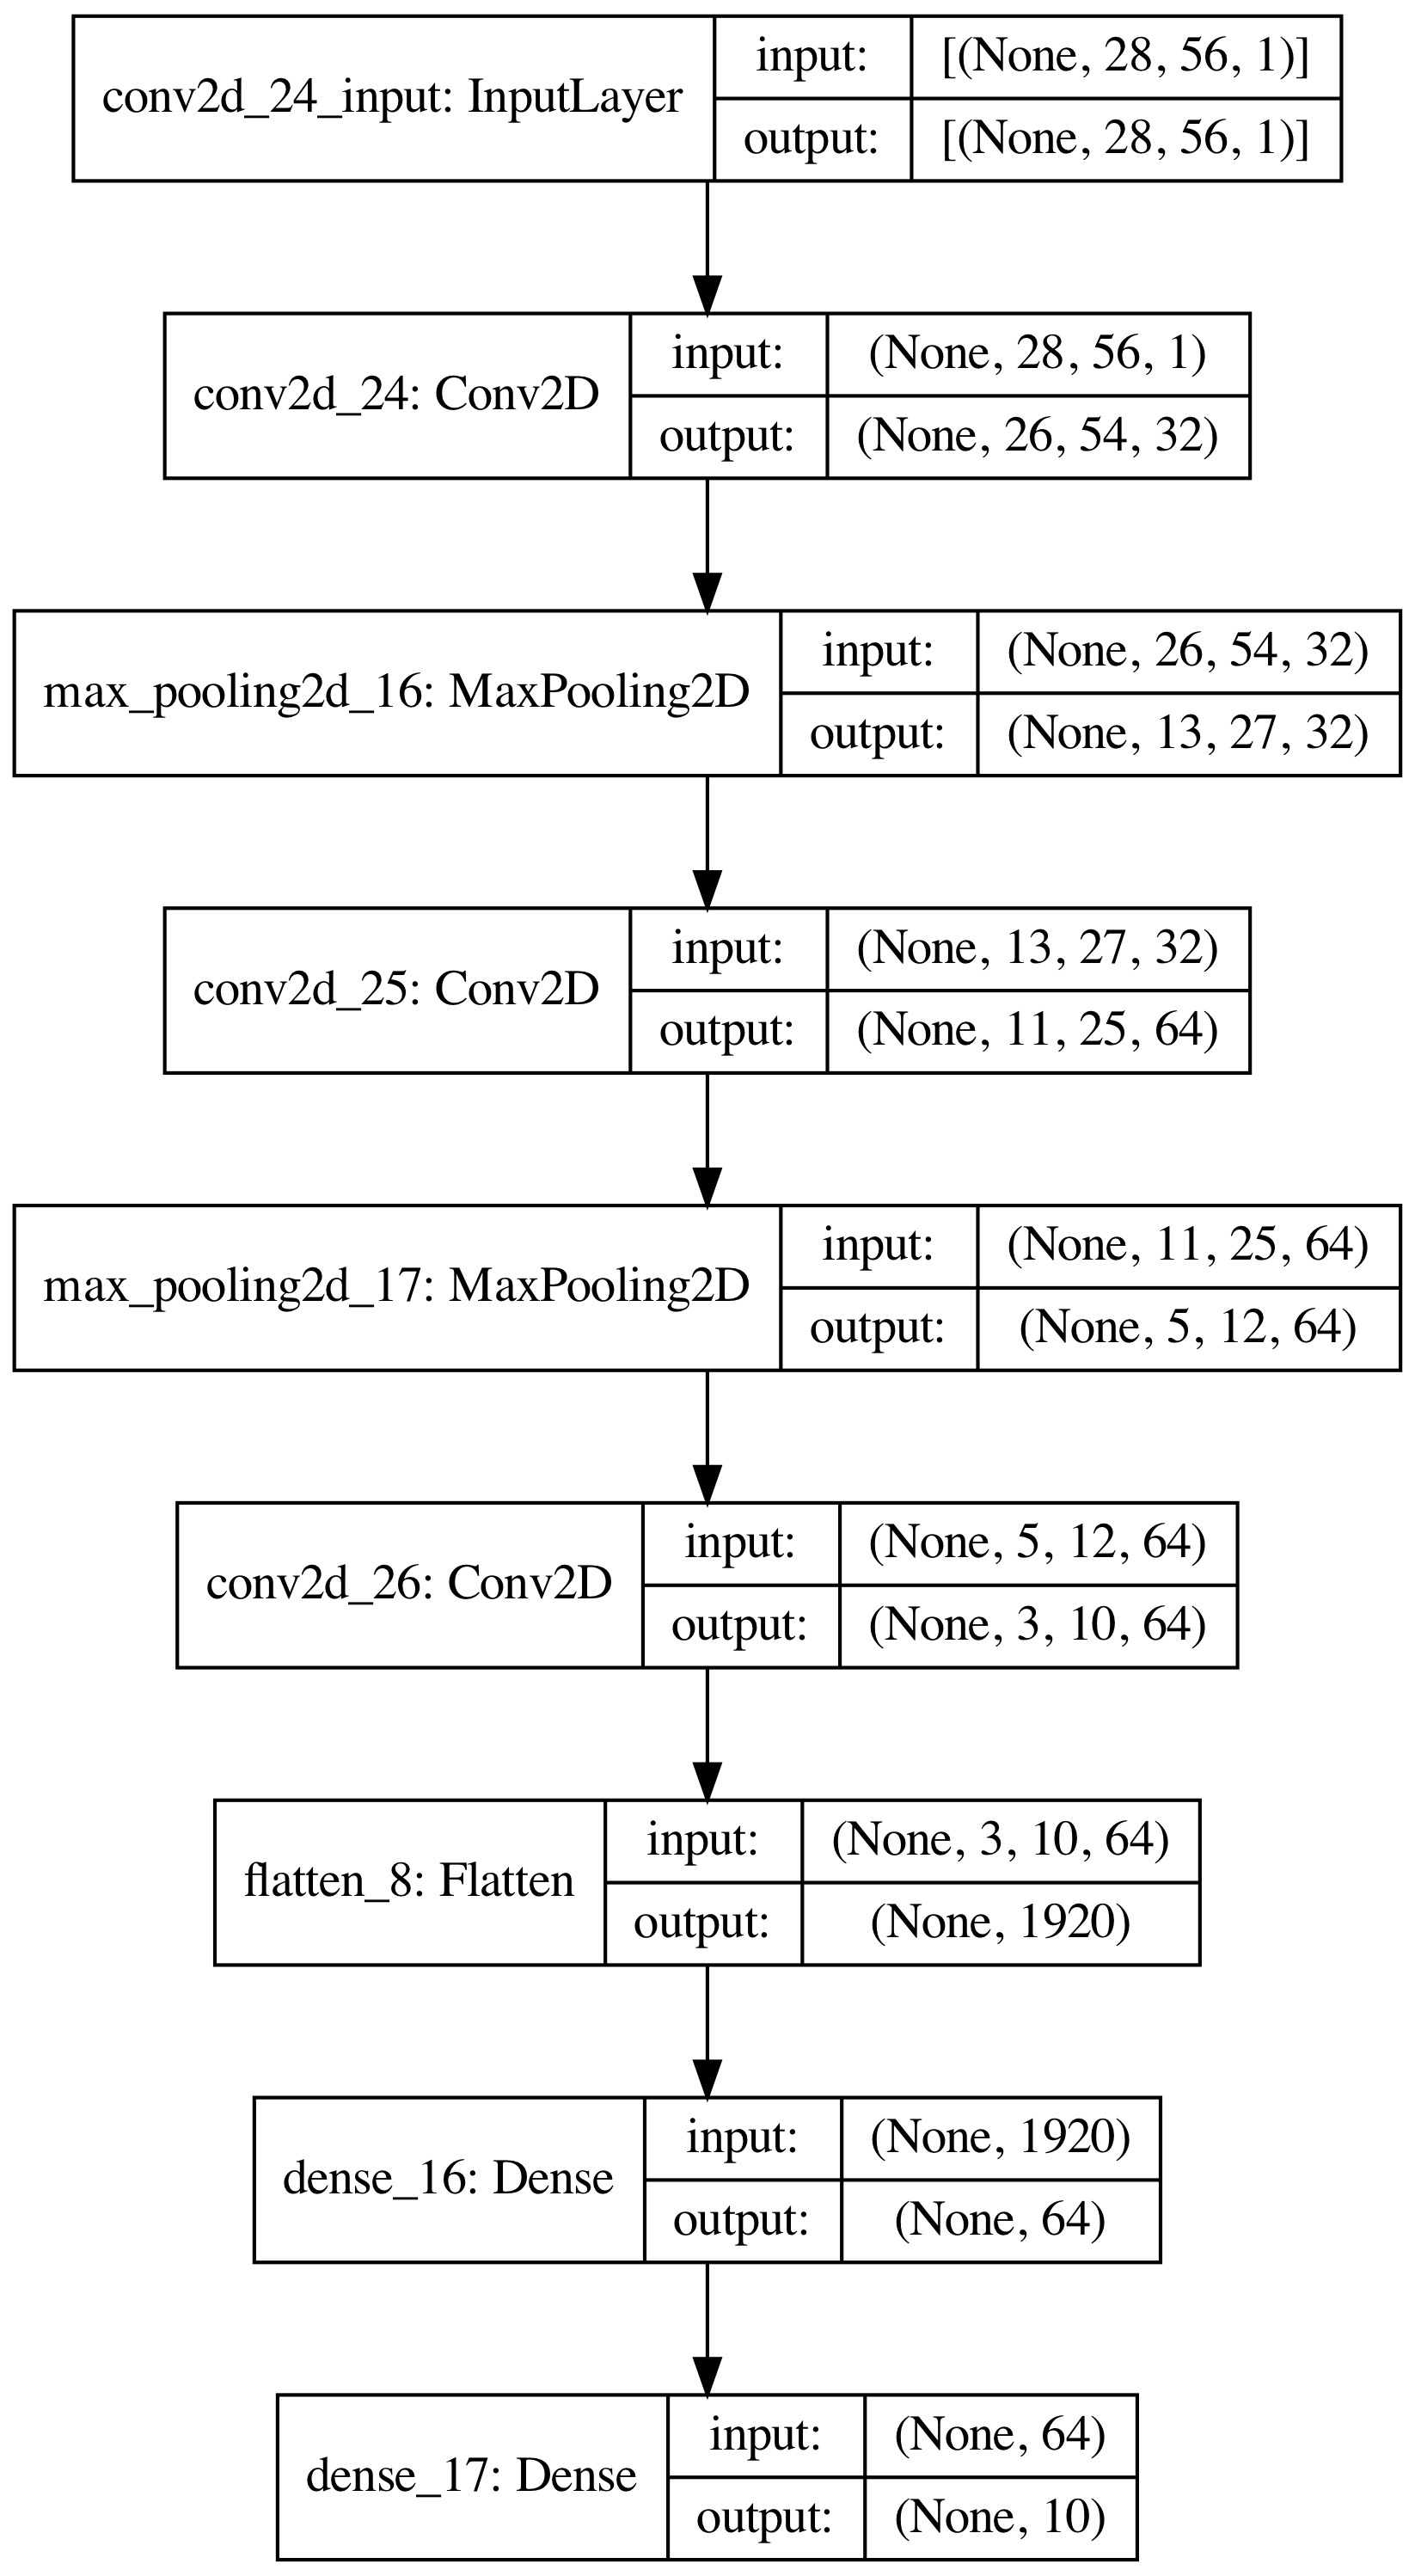

In [53]:
tf.keras.utils.plot_model(DNN_model, "DNN_model.png", show_shapes=True, dpi=300)

In [17]:
# Fit model
DNN_model.fit(train_images, 
          train_labels, 
          epochs = 5, 
          batch_size = 64)

Epoch 1/5
625/625 [==============================] - 65s 100ms/step - loss: 0.2164 - accuracy: 0.9326 - mae: 0.0207
Epoch 2/5
625/625 [==============================] - 66s 105ms/step - loss: 0.0597 - accuracy: 0.9821 - mae: 0.0056
Epoch 3/5
625/625 [==============================] - 62s 99ms/step - loss: 0.0377 - accuracy: 0.9874 - mae: 0.0036
Epoch 4/5
625/625 [==============================] - 60s 97ms/step - loss: 0.0299 - accuracy: 0.9910 - mae: 0.0027
Epoch 5/5
625/625 [==============================] - 61s 98ms/step - loss: 0.0223 - accuracy: 0.9926 - mae: 0.0021


In [18]:
# Print loss, mae and accuracy
DNN_eval_model = DNN_model.evaluate(val_images, val_labels)
DNN_eval_model

625/625 [==============================] - 7s 10ms/step - loss: 14.6404 - accuracy: 0.1159 - mae: 0.1764


[14.64042854309082, 0.11590000241994858, 0.17643354833126068]

In [19]:
# Fit model
DNN_model.fit(train_images, 
          train_labels, 
          epochs = 10, 
          batch_size = 64)

# Print loss, mae and accuracy
DNN_eval_model = DNN_model.evaluate(val_images, val_labels)
DNN_eval_model

Epoch 1/10
625/625 [==============================] - 47s 76ms/step - loss: 0.0203 - accuracy: 0.9939 - mae: 0.0018
Epoch 2/10
625/625 [==============================] - 49s 78ms/step - loss: 0.0167 - accuracy: 0.9945 - mae: 0.0015
Epoch 3/10
625/625 [==============================] - 49s 79ms/step - loss: 0.0137 - accuracy: 0.9955 - mae: 0.0012
Epoch 4/10
625/625 [==============================] - 46s 73ms/step - loss: 0.0133 - accuracy: 0.9960 - mae: 0.0011
Epoch 5/10
625/625 [==============================] - 46s 74ms/step - loss: 0.0113 - accuracy: 0.9962 - mae: 9.8396e-04
Epoch 6/10
625/625 [==============================] - 47s 75ms/step - loss: 0.0118 - accuracy: 0.9963 - mae: 9.3090e-04
Epoch 7/10
625/625 [==============================] - 48s 77ms/step - loss: 0.0110 - accuracy: 0.9963 - mae: 9.2957e-04
Epoch 8/10
625/625 [==============================] - 50s 81ms/step - loss: 0.0098 - accuracy: 0.9969 - mae: 7.9370e-04
Epoch 9/10
625/625 [==============================] - 50

[22.624094009399414, 0.11155000329017639, 0.17761020362377167]

In [ ]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(shape=(None,), name="title")  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(shape=(num_tags,), name="tags")  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)